In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', size=16)
import time
import umap

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [2]:
def init_net():
    
    return nn.Sequential(
              nn.Conv2d(1, 6, kernel_size=3, padding=1), nn.ReLU(),
              nn.Conv2d(6, 6, kernel_size=3, padding=1), nn.ReLU(),
              nn.MaxPool2d(kernel_size=2, stride=2),
              nn.Conv2d(6, 16, kernel_size=3, padding=1), nn.ReLU(),
              nn.MaxPool2d(kernel_size=2, stride=2),
              nn.Flatten(),
              nn.Linear(16 * 7 * 7, 120), nn.ReLU(),
              nn.Linear(120, 100), nn.ReLU(),
              nn.Linear(100, 10)
              )

In [3]:
net = init_net()
net.to(device)

# count total network parameters
print('Total network parameters :', sum(param.numel() for param in net.parameters() if param.requires_grad))

Total network parameters : 108580


In [4]:
X = torch.randn(1, 1, 28, 28).to(device)

print('Input shape:\t', X.shape)

for layer in net:
    X=layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Input shape:	 torch.Size([1, 1, 28, 28])
Conv2d output shape:	 torch.Size([1, 6, 28, 28])
ReLU output shape:	 torch.Size([1, 6, 28, 28])
Conv2d output shape:	 torch.Size([1, 6, 28, 28])
ReLU output shape:	 torch.Size([1, 6, 28, 28])
MaxPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 14, 14])
ReLU output shape:	 torch.Size([1, 16, 14, 14])
MaxPool2d output shape:	 torch.Size([1, 16, 7, 7])
Flatten output shape:	 torch.Size([1, 784])
Linear output shape:	 torch.Size([1, 120])
ReLU output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 100])
ReLU output shape:	 torch.Size([1, 100])
Linear output shape:	 torch.Size([1, 10])


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [5]:
transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()])

fmnist_train = datasets.FashionMNIST(
    root="../../../data", train=True, transform=transform, download=True)
fmnist_test = datasets.FashionMNIST(
    root="../../../data", train=False, transform=transform, download=True)

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


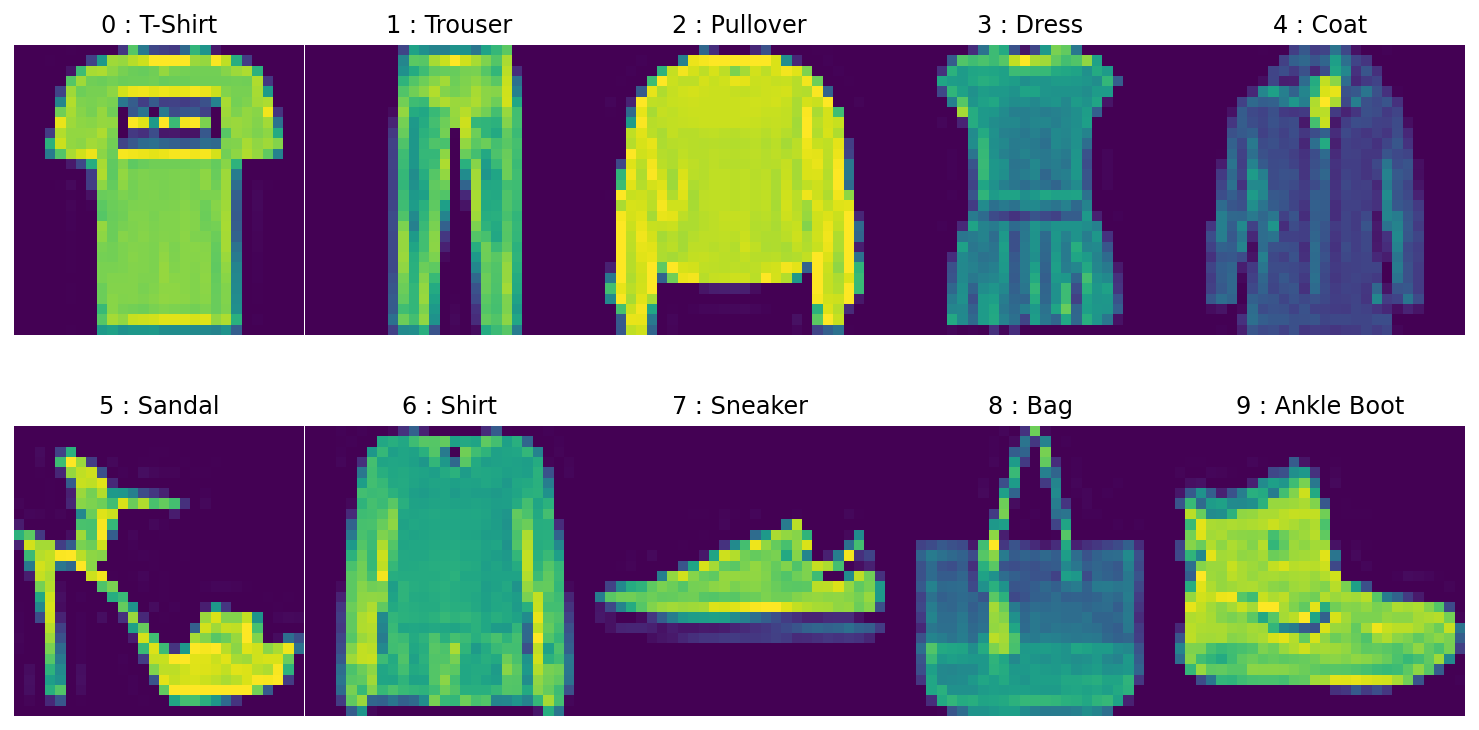

In [6]:
labels_map = {
    0: "T-Shirt",     # 1
    1: "Trouser",     # 16
    2: "Pullover",    # 7
    3: "Dress",       # 3
    4: "Coat",        # 19
    5: "Sandal",      # 9
    6: "Shirt",       # 18
    7: "Sneaker",     # 6
    8: "Bag",         # 35
    9: "Ankle Boot",  # 0
}

fig, axes = plt.subplots(2, 5, figsize=(13, 7))
plt.subplots_adjust(hspace=0.001, wspace=0.001)

for i, ID in enumerate([1, 16, 7, 3, 19]):
    image, label = fmnist_train.__getitem__(ID)
    axes[0][i].imshow(image.squeeze().numpy())
    axes[0][i].set_title(f'{label} : {labels_map[label]}')
    axes[0][i].axis('off')

for i, ID in enumerate([9, 18, 6, 35, 0]):
    image, label = fmnist_train.__getitem__(ID)
    axes[1][i].imshow(image.squeeze().numpy())
    axes[1][i].set_title(f'{label} : {labels_map[label]}')
    axes[1][i].axis('off')

In [7]:
batch_size = 128

train_loader = DataLoader(fmnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(fmnist_test, batch_size=batch_size, shuffle=True)

In [8]:
# Loss
criterion = nn.CrossEntropyLoss()


# Optimizer
learning_rate = 0.2
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2, 5, 8, 11, 14], gamma=0.5)

#optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999))

In [9]:
def train_1_epoch(model, optimizer, train_loss, train_acc, lr_record, scheduler=None):
    
    model.train()              # set model to training mode

    running_loss = 0.
    running_corrects = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device) 
        labels = labels.to(device)
        
        # forward
        outputs = model(images)
        
        # loss
        loss = criterion(outputs, labels) # predicted outputs v.s. actual labels
        
        # backwards
        optimizer.zero_grad()  # zero gradient
        loss.backward()        # loss.backward would calculate dloss/dw_i  
        optimizer.step()       # update network parameters (w_i)
        
        # compute statistics (avg. loss, accuracy)
        running_loss += loss.item() * labels.size(0)
        _, predictions = torch.max(outputs, 1)
        running_corrects += torch.sum(predictions == labels.data)
        
        #if (i+1)%300 == 0: # every 300 steps, print something
        #    print(f'epoch {epoch+1}/{num_epochs}, step {i+1}/{len(train_loader)}, loss={loss.item():.4f}')
    
    # -- End training for 1 epoch -- record statistics
    if scheduler:
        scheduler.step()
    
    lr_record.append(optimizer.state_dict()['param_groups'][0]['lr'])
    #lr_record.append(scheduler.get_last_lr()[0]) # if scheduler is specified
    
    epoch_loss = running_loss / len(fmnist_train)            ; train_loss.append(epoch_loss)
    epoch_acc  = running_corrects / len(fmnist_train) * 100. ; train_acc.append(epoch_acc)
    
    if (epoch%1)==0 :
        print(f'>>> End epoch {epoch+1}, train accuracy = {epoch_acc:.2f}%, train avgLoss = {epoch_loss:.4f}')

    
def validation(model, valid_loss, valid_acc):
    
    model.eval()              # set model to evaluation mode
    
    running_loss = 0.
    running_corrects = 0
    
    for i, (images, labels) in enumerate(test_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        # compute statistics (avg. loss, accuracy)
        running_loss += loss.item() * labels.size(0)
        _, predictions = torch.max(outputs, 1)
        running_corrects += torch.sum(predictions == labels.data)
    
    valid_loss.append(running_loss/len(test_loader.dataset))
    valid_acc.append(running_corrects/len(test_loader.dataset) * 100.)
    print(f'>>>              valid accuracy = {valid_acc[-1]:.2f}%, valid avgLoss = {valid_loss[-1]:.4f}')

In [10]:
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []
lr_record = []

num_epochs = 15
for epoch in range(0, num_epochs):
    #since = time.time()
    
    train_1_epoch(net, optimizer, train_loss, train_acc, lr_record, scheduler)
    validation(net, valid_loss, valid_acc)
    
    #time_elapsed = time.time() - since
    #print(f'\tTime: {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    
    torch.save(net.state_dict(), f'./experiments/CNN_SGD_lr{learning_rate}_run1_ep{epoch}.params')

>>> End epoch 1, train accuracy = 60.99%, train avgLoss = 1.0067
>>>              valid accuracy = 76.29%, valid avgLoss = 0.6165
>>> End epoch 2, train accuracy = 83.09%, train avgLoss = 0.4504
>>>              valid accuracy = 83.59%, valid avgLoss = 0.4312
>>> End epoch 3, train accuracy = 87.05%, train avgLoss = 0.3485
>>>              valid accuracy = 86.48%, valid avgLoss = 0.3633
>>> End epoch 4, train accuracy = 88.01%, train avgLoss = 0.3211
>>>              valid accuracy = 86.76%, valid avgLoss = 0.3588
>>> End epoch 5, train accuracy = 88.75%, train avgLoss = 0.3026
>>>              valid accuracy = 86.82%, valid avgLoss = 0.3551
>>> End epoch 6, train accuracy = 89.79%, train avgLoss = 0.2742
>>>              valid accuracy = 88.80%, valid avgLoss = 0.3077
>>> End epoch 7, train accuracy = 90.15%, train avgLoss = 0.2649
>>>              valid accuracy = 88.48%, valid avgLoss = 0.3092
>>> End epoch 8, train accuracy = 90.51%, train avgLoss = 0.2580
>>>              valid ac

In [ ]:
# ### Save training logs
# import pickle

# logdic = {'train_loss':train_loss, 'train_acc':train_acc, 'valid_loss':valid_loss, 'valid_acc':valid_acc}

# fileObject = open(f'CNN_SGD_lr{learning_rate}_run1.log', 'wb')
# pickle.dump(logdic, fileObject)
# fileObject.close()

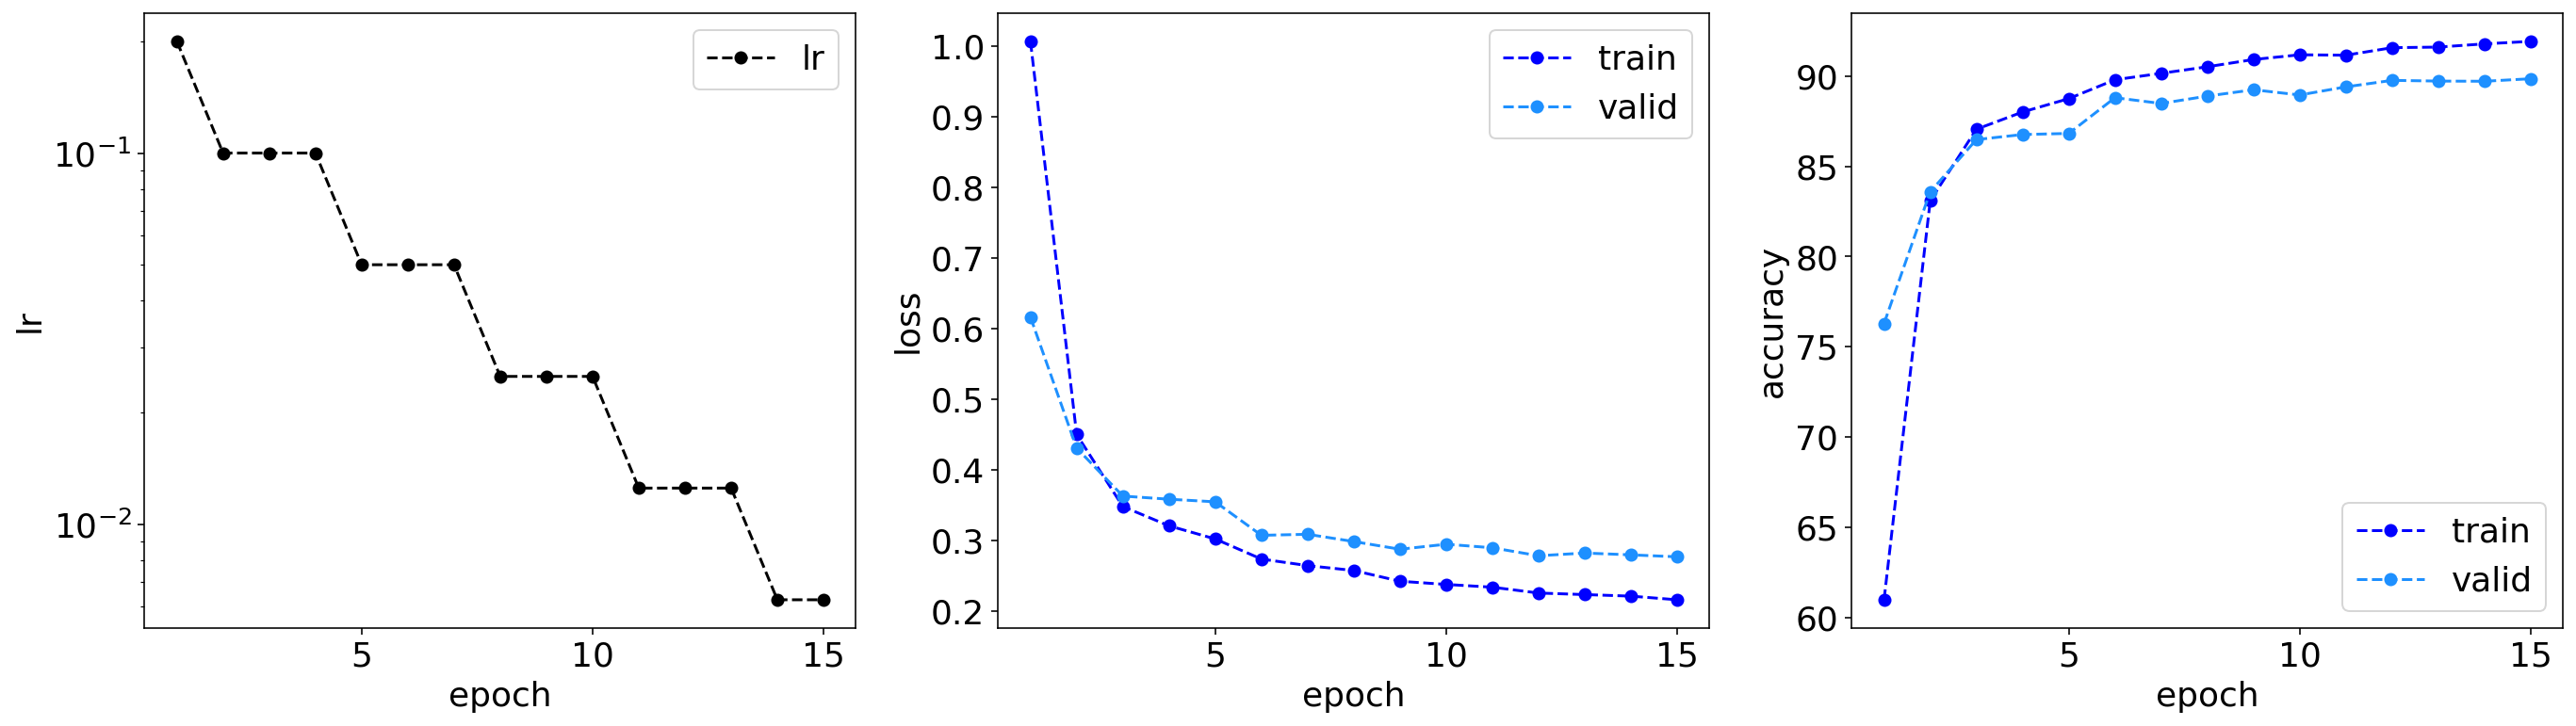

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(23, 6))
plt.rc('font', size=18)

ax[0].plot(range(1,num_epochs+1), lr_record, 'o--', label='lr', color='k')
ax[0].set_ylabel('lr')
ax[0].set_yscale('log')

ax[1].plot(range(1,num_epochs+1)[::], train_loss[::], 'o--', label='train', color='b')
ax[1].plot(range(1,num_epochs+1)[::], valid_loss[::], 'o--', label='valid', color='dodgerblue')
ax[2].plot(range(1,num_epochs+1)[::], train_acc[::] , 'o--', label='train', color='b')
ax[2].plot(range(1,num_epochs+1)[::], valid_acc[::] , 'o--', label='valid', color='dodgerblue')

ax[1].set_ylabel('loss')
ax[2].set_ylabel('accuracy')

for i in range(3):
    ax[i].set_xlabel('epoch')
    ax[i].legend(loc='best')

# View Network Weight Parameters

In [13]:
def get_weights(model, layerID, in_channelID=None, out_channelID=None):
    '''plot filters of channels 
        If in_channelID  is given, plot filters of all out_channels (at fixed in_channelID ).
        If out_channelID is given, plot filters of all in_channels  (at fixed out_channelID).
    '''
    
    if in_channelID is not None:
        layerW = model[layerID].weight.data[:,in_channelID,:,:].cpu().numpy()
    if out_channelID is not None:
        layerW = model[layerID].weight.data[out_channelID,:,:,:].cpu().numpy()
    
    return layerW

def view_3D_cubes(cube3D, Ncols, Nrows, figsize, cmap='Greys'):
    
    fig, axs = plt.subplots(Nrows, Ncols, figsize=figsize)
    plt.subplots_adjust(hspace=0.001, wspace=0.001)
    
    for i in range(Nrows):    
        for j in range(Ncols):
    
            axs[i,j].imshow(cube3D[i*Ncols+j], cmap=cmap)
            axs[i,j].axis('off')
    return fig, axs

In [14]:
epochID = 14
fname_params = f'./experiments/CNN_SGD_lr{learning_rate}_run1_ep{epochID}.params'
print(f'load parameter file {fname_params} to nework')
net.load_state_dict(torch.load(fname_params))
net.eval()

load parameter file ./experiments/CNN_SGD_lr0.2_run1_ep14.params to nework


Sequential(
  (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=784, out_features=120, bias=True)
  (10): ReLU()
  (11): Linear(in_features=120, out_features=100, bias=True)
  (12): ReLU()
  (13): Linear(in_features=100, out_features=10, bias=True)
)

### First ConV layer 

Input 1x28x28 ------ 1st Conv layer (3x3) ------->  Output 6x28x28

Weight Matrix for 1st Conv layer : 6x1x28x28



-1.6490731
1.0122961


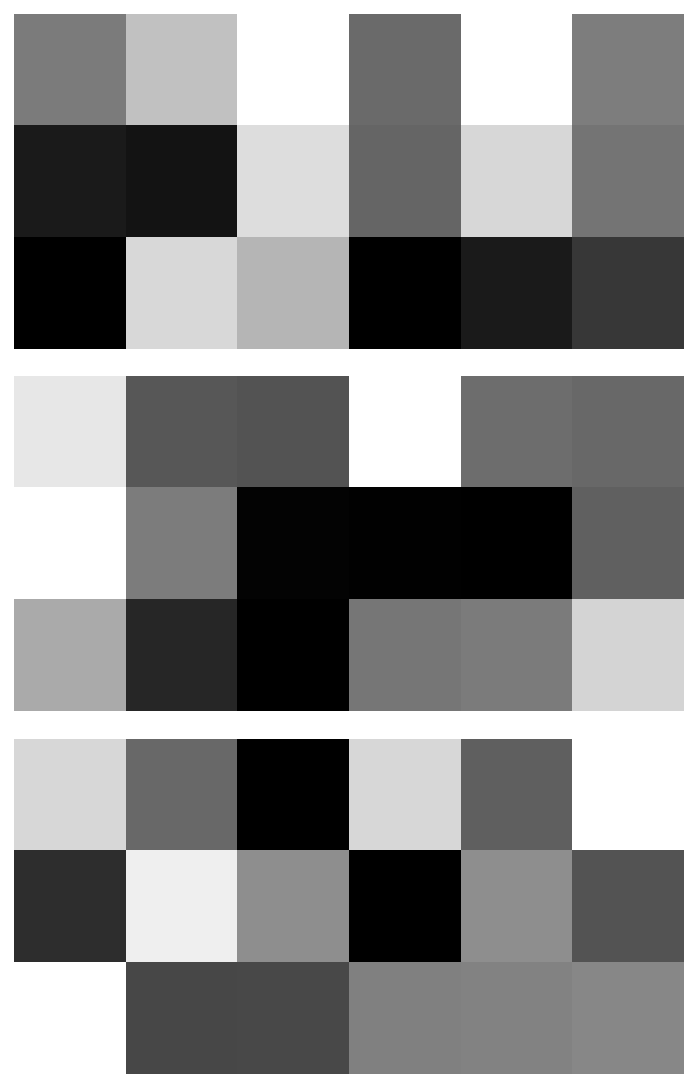

In [15]:
layerW = get_weights(net, 0, in_channelID=0)
_,__ = view_3D_cubes(layerW, Ncols=2, Nrows=3, figsize=(6,10), cmap='Greys')

print(layerW.min())
print(layerW.max())

### Second ConV layer 

Input 6x28x28 ------ 2nd Conv layer (3x3) ------->  Output 6x28x28

Weight Matrix for 2nd Conv layer : 6x6x28x28

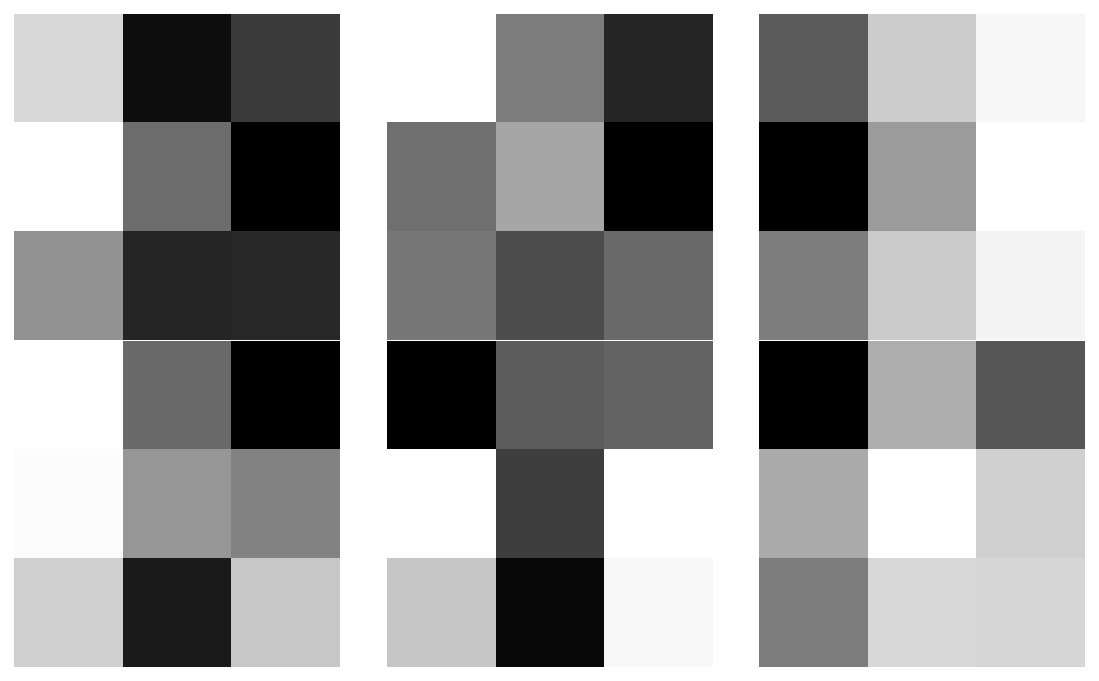

In [16]:
layerW = get_weights(net, 2, out_channelID=0)
_,__ = view_3D_cubes(layerW, Ncols=3, Nrows=2, figsize=(10,6), cmap='Greys')

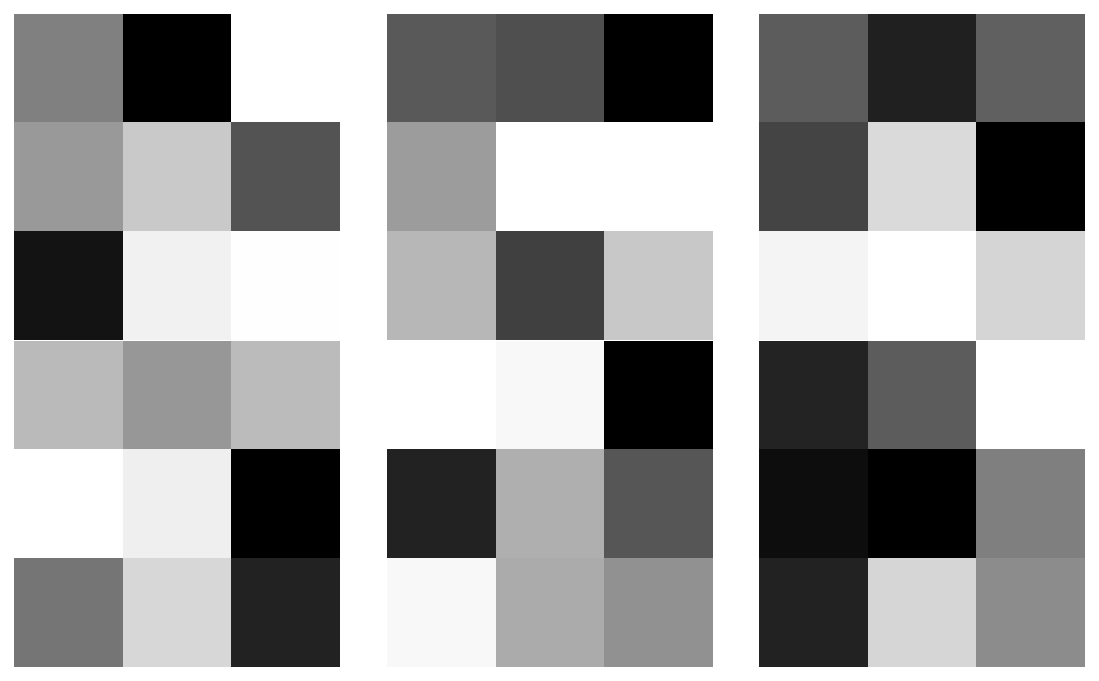

In [17]:
layerW = get_weights(net, 2, out_channelID=5)
_,__ = view_3D_cubes(layerW, Ncols=3, Nrows=2, figsize=(10,6), cmap='Greys')

# View Feature Maps

### Check Feature Maps after the 1st layer Convolution

In [18]:
layerW = get_weights(net, 0, in_channelID=0)
layerW.shape

(6, 3, 3)

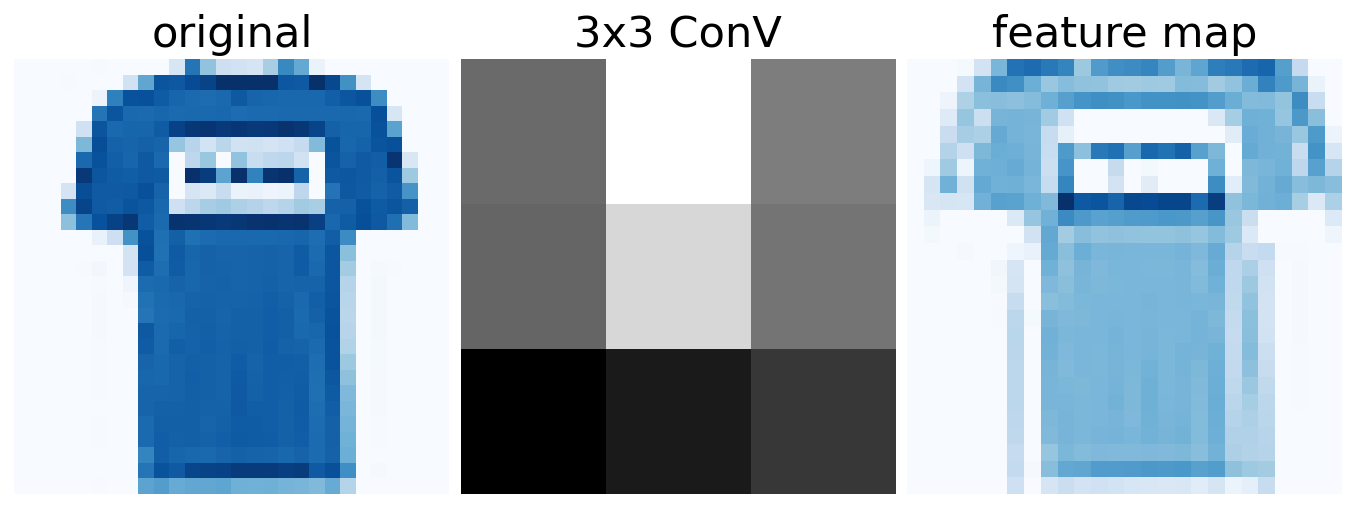

In [19]:
channelID = 1

conv2d = nn.Conv2d(1, 1, kernel_size=(3, 3), bias=False)
conv2d.weight.data = torch.tensor(layerW[channelID]).view(1, 1, 3,3)


imageID = 1
X, _ = fmnist_train.__getitem__(imageID)
outX = conv2d(X.unsqueeze(dim=0))  # Convolution
outX = nn.ReLU()(outX)             # Apply ReLU

###############

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
plt.subplots_adjust(hspace=0.001, wspace=0.001)
axes[0].imshow(X.squeeze().numpy(), cmap='Blues')
axes[1].imshow(layerW[channelID], cmap='Greys')
axes[2].imshow(outX.squeeze().detach().numpy(), cmap='Blues')

axes[0].set_title('original')
axes[1].set_title('3x3 ConV')
axes[2].set_title('feature map')

for i in range(3):
    axes[i].axis('off')

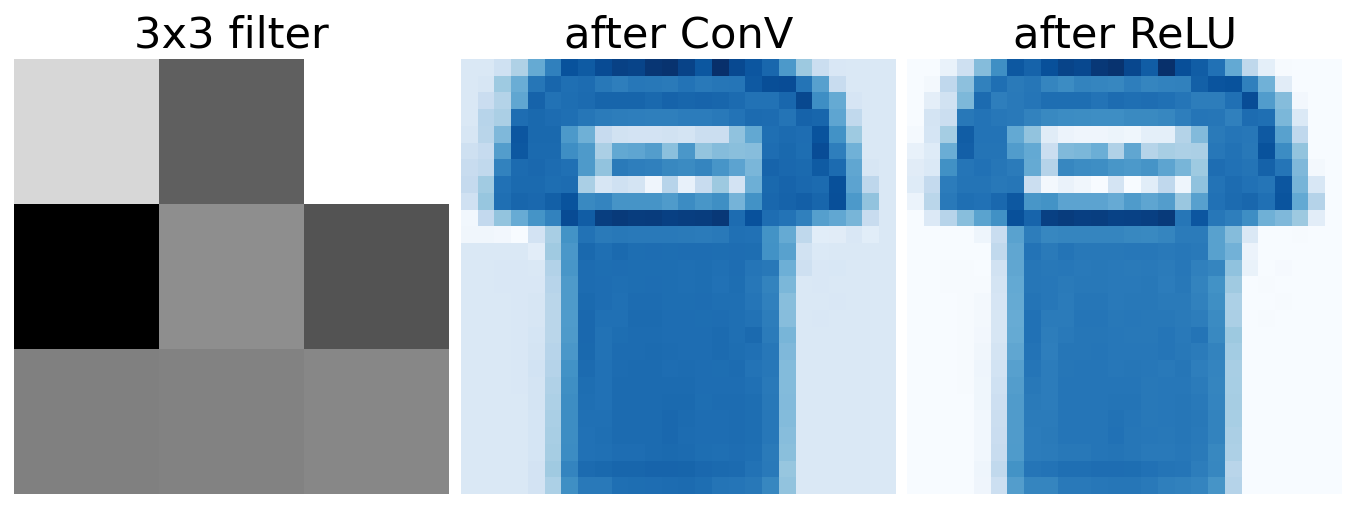

In [20]:
channelID = 5

conv2d = nn.Conv2d(1, 1, kernel_size=(3, 3), bias=False)
conv2d.weight.data = torch.tensor(layerW[channelID]).view(1, 1, 3,3)


imageID = 1
X, _ = fmnist_train.__getitem__(imageID)
outXc = conv2d(X.unsqueeze(dim=0))  # Convolution
outX = nn.ReLU()(outXc)             # Apply ReLU

###############

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
plt.subplots_adjust(hspace=0.001, wspace=0.001)

axes[0].imshow(layerW[channelID], cmap='Greys')
axes[1].imshow(outXc.squeeze().detach().numpy(), cmap='Blues')
axes[2].imshow(outX.squeeze().detach().numpy(), cmap='Blues')


axes[0].set_title('3x3 filter')
axes[1].set_title('after ConV')
axes[2].set_title('after ReLU')


for i in range(3):
    axes[i].axis('off')

### Extract output features given a layerID and an image

In [21]:
def get_features(model, image, layer_to_visualize):
    
    modulelist = list(net.modules())
    
    for count, layer in enumerate(modulelist[1:]):
        layer.cpu()
        
        with torch.no_grad() :
            image = layer(image)
        
        if count == layer_to_visualize:
            output = image
        
    output = output.squeeze().numpy()
        
    return output

torch.Size([1, 1, 28, 28])


(-0.5, 27.5, 27.5, -0.5)

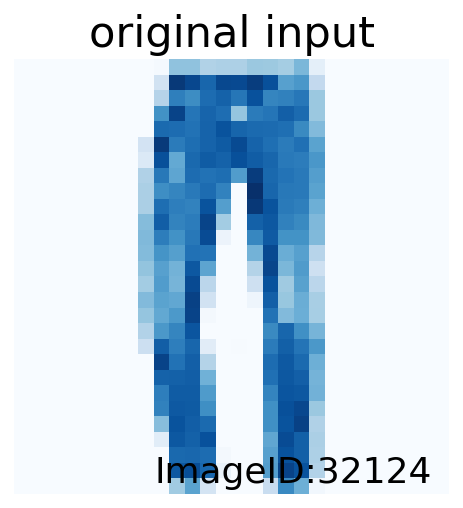

In [22]:
imageID = 32124
image, _ = fmnist_train.__getitem__(imageID)
image = image.unsqueeze(dim=0)
print(image.shape)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.imshow(image.squeeze().numpy(), cmap='Blues')

ax.text(0.96, 0.01, f'ImageID:{imageID}',
                           verticalalignment='bottom', horizontalalignment='right',
                           transform=ax.transAxes,
                           color='k', fontsize=18)

ax.set_title('original input')
ax.axis('off')

output feature volume dimension: (6, 28, 28)


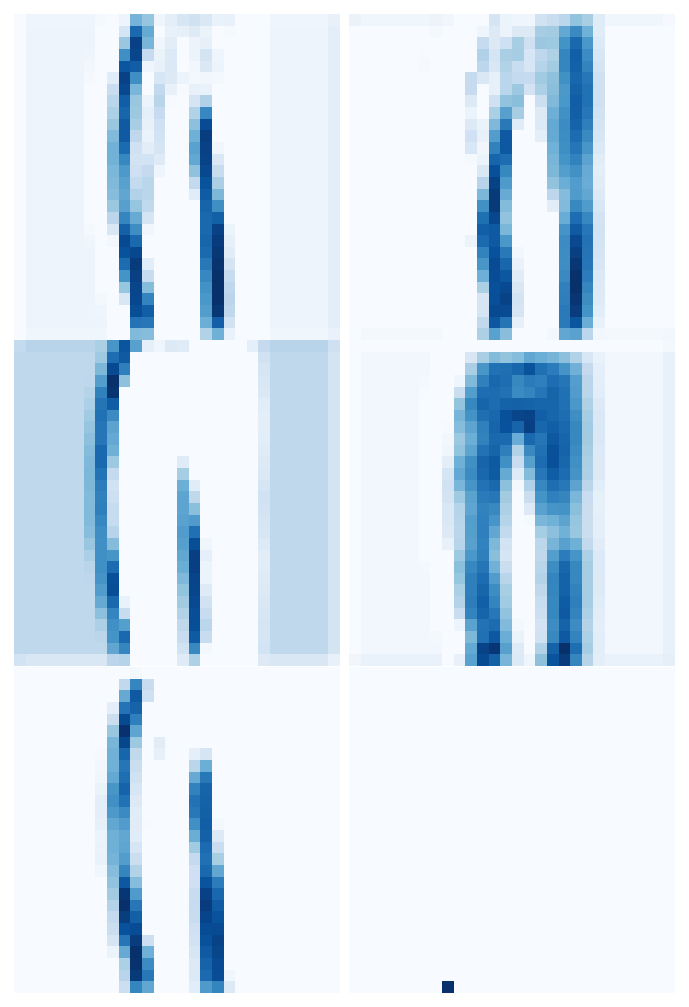

In [23]:
output = get_features(net, image, layer_to_visualize=3)
print('output feature volume dimension:', output.shape)

fig, axs = view_3D_cubes(output, Ncols=2, Nrows=3, figsize=(6,9), cmap='Blues')

In [24]:
net

Sequential(
  (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=784, out_features=120, bias=True)
  (10): ReLU()
  (11): Linear(in_features=120, out_features=100, bias=True)
  (12): ReLU()
  (13): Linear(in_features=100, out_features=10, bias=True)
)

# Last layer & UMAP

In [25]:
# define a new network and load pre-trained parameters to it.
epochID = 14
trained_net = init_net()
trained_net.load_state_dict(torch.load(f'./experiments/CNN_SGD_lr{learning_rate}_run1_ep{epochID}.params'))
trained_net.eval()

Sequential(
  (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=784, out_features=120, bias=True)
  (10): ReLU()
  (11): Linear(in_features=120, out_features=100, bias=True)
  (12): ReLU()
  (13): Linear(in_features=100, out_features=10, bias=True)
)

### To extract the last output features, change the last layer to nn.Flatten

In [26]:
trained_net[13]

Linear(in_features=100, out_features=10, bias=True)

In [27]:
trained_net[13] = nn.Flatten()
trained_net

Sequential(
  (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=784, out_features=120, bias=True)
  (10): ReLU()
  (11): Linear(in_features=120, out_features=100, bias=True)
  (12): ReLU()
  (13): Flatten(start_dim=1, end_dim=-1)
)

In [28]:
X = torch.randn(1, 1, 28, 28)

print('Input shape:\t', X.shape)

for layer in trained_net:
    X=layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Input shape:	 torch.Size([1, 1, 28, 28])
Conv2d output shape:	 torch.Size([1, 6, 28, 28])
ReLU output shape:	 torch.Size([1, 6, 28, 28])
Conv2d output shape:	 torch.Size([1, 6, 28, 28])
ReLU output shape:	 torch.Size([1, 6, 28, 28])
MaxPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 14, 14])
ReLU output shape:	 torch.Size([1, 16, 14, 14])
MaxPool2d output shape:	 torch.Size([1, 16, 7, 7])
Flatten output shape:	 torch.Size([1, 784])
Linear output shape:	 torch.Size([1, 120])
ReLU output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 100])
ReLU output shape:	 torch.Size([1, 100])
Flatten output shape:	 torch.Size([1, 100])


In [29]:
def get_LLfeatures_allData(model, data_loader, device='cpu'):
    
    model.eval()
    model.to(device)
    
    out_features = []
    out_labels = []
    
    for i, (images, labels) in enumerate(data_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        with torch.no_grad():
            
            features = model(images) # the last FC layer feature vector 
            
            out_labels.extend(labels.cpu().tolist())
            out_features.extend(features.cpu().tolist())
    
    return out_labels, np.array(out_features)

In [30]:
out_labels, out_features = get_LLfeatures_allData(trained_net, test_loader)
print('out_features.shape :', out_features.shape)

u = umap.UMAP(n_neighbors=5).fit_transform(out_features)

out_features.shape : (10000, 100)


[Text(1, 0.0, 'T-Shirt'),
 Text(1, 1.0, 'Trouser'),
 Text(1, 2.0, 'Pullover'),
 Text(1, 3.0, 'Dress'),
 Text(1, 3.9999999999999996, 'Coat'),
 Text(1, 5.0, 'Sandal'),
 Text(1, 6.0, 'Shirt'),
 Text(1, 7.0, 'Sneaker'),
 Text(1, 7.999999999999999, 'Bag'),
 Text(1, 9.0, 'Ankle Boot')]

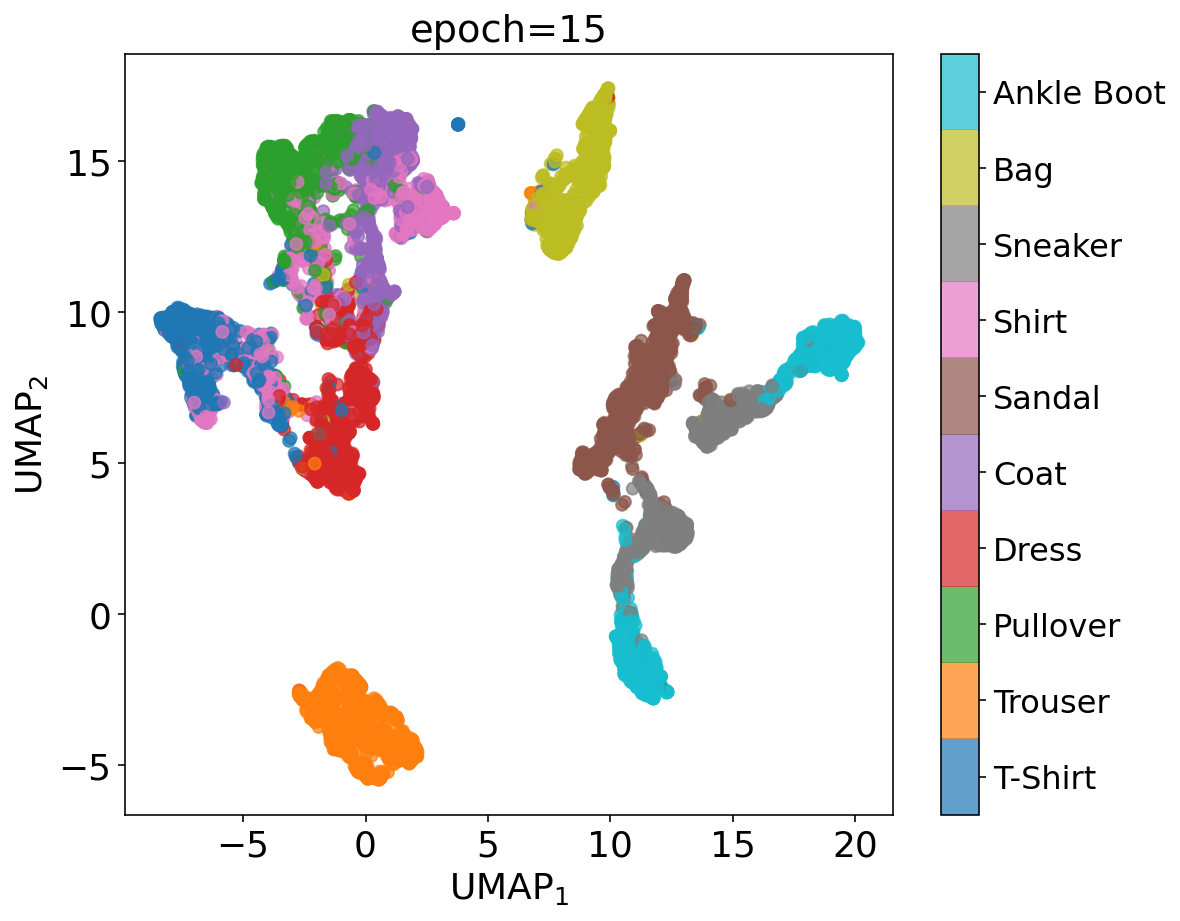

In [31]:
fig, ax = plt.subplots(figsize=(8.6, 7))
plt.rc('font', size=16)

s = ax.scatter(u[:,0], u[:,1], c=out_labels, cmap='tab10', alpha=0.7)
#ax.set_title(f'epoch=0')
ax.set_title(f'epoch={epochID+1}')


#ax.set_title(f'UMAP of trained features (epoch={epochID+1})')


ax.set_xlabel(r'UMAP$_1$')
ax.set_ylabel(r'UMAP$_2$')


cbar = fig.colorbar(s, ticks=range(10), boundaries=np.arange(11) - .5) #
cbar.ax.set_yticklabels([labels_map[i] for i in range(10)])